Shape: (45202, 40)


,airport,flight_month,year,month,carrier,carrier_name,arr_flights,arr_del15,carrier_ct,weather_ct,...,avg_humidity,n_storms,season,subbasin,name,lat,lon,wind_kt,pressure_hpa,sshs_category
0,EWR,2025-01-01 00:00:00,2025,1,G4,Allegiant Air,31.0,5.0,2.17,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,LAS,2025-01-01 00:00:00,2025,1,G4,Allegiant Air,575.0,151.0,27.17,16.06,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,LAX,2025-01-01 00:00:00,2025,1,G4,Allegiant Air,37.0,11.0,1.32,1.76,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,MCO,2025-01-01 00:00:00,2025,1,G4,Allegiant Air,32.0,3.0,0.00,0.17,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,PHX,2025-01-01 00:00:00,2025,1,G4,Allegiant Air,28.0,7.0,4.53,1.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


['airport', 'flight_month', 'year', 'month', 'carrier', 'carrier_name', 'arr_flights', 'arr_del15', 'carrier_ct', 'weather_ct', 'nas_ct', 'security_ct', 'late_aircraft_ct', 'arr_cancelled', 'arr_diverted', 'arr_delay', 'carrier_delay', 'weather_delay', 'nas_delay', 'security_delay', 'late_aircraft_delay', 'avg_wind_speed', 'total_precip', 'total_snow', 'max_temp', 'min_temp', 'avg_temp', 'max_2min_wind', 'max_5sec_wind', 'avg_wetbulb_temp', 'avg_humidity', 'n_storms', 'season', 'subbasin', 'name', 'lat', 'lon', 'wind_kt', 'pressure_hpa', 'sshs_category']
  airport  year  month  arr_flights  arr_del15  delay_rate  delayed
0     EWR  2025      1         31.0        5.0    0.161290        1
1     LAS  2025      1        575.0      151.0    0.262609        1
2     LAX  2025      1         37.0       11.0    0.297297        1
3     MCO  2025      1         32.0        3.0    0.093750        0
4     PHX  2025      1         28.0        7.0    0.250000        1
Class balance:
 delayed
1    0.

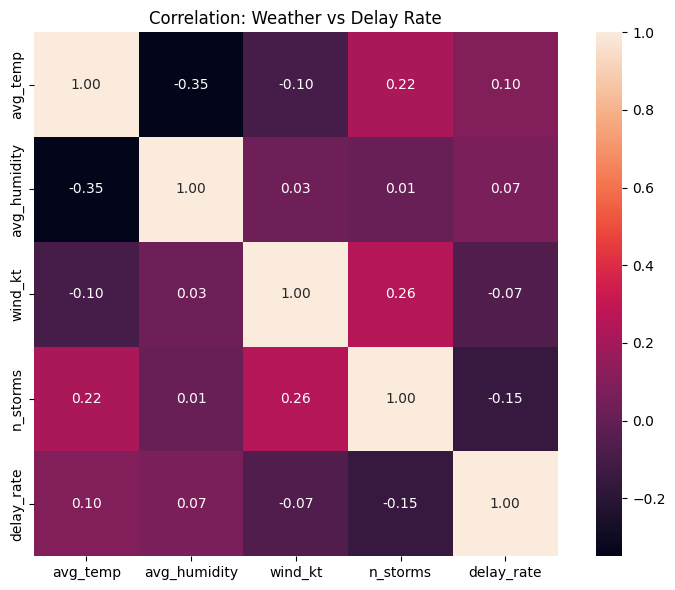

Numeric features: ['avg_temp', 'avg_humidity', 'wind_kt', 'n_storms', 'arr_flights', 'carrier_ct', 'weather_ct', 'nas_ct', 'security_ct', 'late_aircraft_ct']
Categorical features: ['airport', 'carrier', 'season', 'subbasin', 'name']
Classification report:
               precision    recall  f1-score   support

           0       0.99      0.94      0.97      2876
           1       0.97      1.00      0.99      6162

    accuracy                           0.98      9038
   macro avg       0.98      0.97      0.98      9038
weighted avg       0.98      0.98      0.98      9038

ROC-AUC: 0.9986616003961649


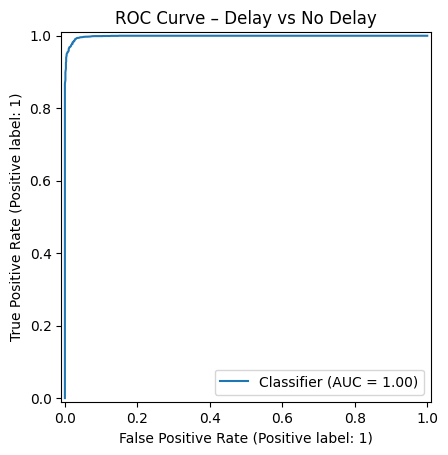

Top 15 features:


,feature,importance
4,arr_flights,0.142283
7,nas_ct,0.117363
9,late_aircraft_ct,0.112699
5,carrier_ct,0.103623
1,avg_humidity,0.053388
6,weather_ct,0.053319
0,avg_temp,0.049540
57,season_2020.0,0.041774
2,wind_kt,0.021939
8,security_ct,0.020171


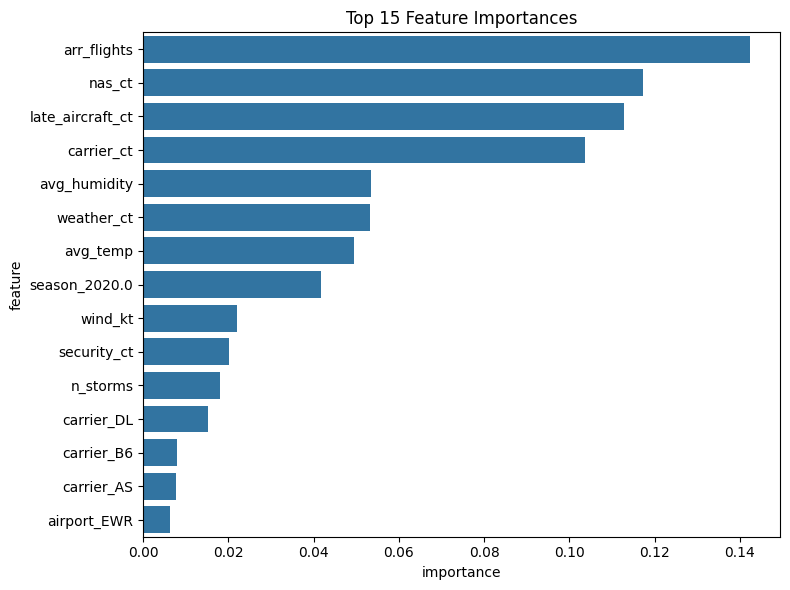

Predicted probability of delay: 88.67%
Predicted class (1 = delayed, 0 = not delayed): 1


In [1]:
# ============================================
# STEP 1 – Imports
# ============================================
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, RocCurveDisplay
from sklearn.impute import SimpleImputer   # <--- NEW

# ============================================
# STEP 2 – Load data
# ============================================
df = pd.read_csv("fact_monthly_delay_weather_hurricane.csv")

print("Shape:", df.shape)
display(df.head())
print(df.columns.tolist())

# If you have 'flight_month' as text and want it as date:
if "flight_month" in df.columns:
    df["flight_month"] = pd.to_datetime(df["flight_month"])

# ============================================
# STEP 3 – Create delay_rate and delayed label
# ============================================
if {"arr_flights", "arr_del15"}.issubset(df.columns):
    df = df[df["arr_flights"] > 0].copy()   # avoid divide by 0
    df["delay_rate"] = df["arr_del15"] / df["arr_flights"]
else:
    raise ValueError("Adjust column names for arr_flights / arr_del15.")

df["delayed"] = (df["delay_rate"] > 0.15).astype(int)

print(df[["airport", "year", "month", "arr_flights",
          "arr_del15", "delay_rate", "delayed"]].head())
print("Class balance:\n", df["delayed"].value_counts(normalize=True))

# ============================================
# STEP 4 – Pick weather columns & correlation
# ============================================
candidate_weather_cols = [c for c in df.columns
                          if any(k in c.lower() for k in
                                 ["temp", "humid", "precip", "wind", "storm"])]
print("Guessed weather columns:", candidate_weather_cols)

# EDIT these names if needed based on the printout above
weather_cols = [c for c in [
    "avg_temp", "avg_humidity", "precip_in", "wind_kt", "n_storms"
] if c in df.columns]

print("Using weather columns:", weather_cols)

corr_cols = weather_cols + ["delay_rate"]
corr_df = df[corr_cols].dropna()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_df.corr(), annot=True, fmt=".2f", square=True)
plt.title("Correlation: Weather vs Delay Rate")
plt.tight_layout()
plt.show()

# ============================================
# STEP 5 – Define features X and target y
# ============================================
y = df["delayed"]

numeric_features = weather_cols + [
    c for c in ["arr_flights", "carrier_ct", "weather_ct",
                "nas_ct", "security_ct", "late_aircraft_ct"]
    if c in df.columns
]

categorical_features = [c for c in
                        ["airport", "carrier", "season", "subbasin", "name"]
                        if c in df.columns]

print("Numeric features:", numeric_features)
print("Categorical features:", categorical_features)

X = df[numeric_features + categorical_features].copy()

# ============================================
# STEP 6 – Train / test split
# ============================================
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# ============================================
# STEP 7 – Preprocessing + model (WITH IMPUTERS)
# ============================================
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),   # <--- NEW
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),  # <--- NEW
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

model = RandomForestClassifier(
    n_estimators=300,
    random_state=42,
    n_jobs=-1
)

clf = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", model)
])

# ============================================
# STEP 8 – Train model
# ============================================
clf.fit(X_train, y_train)

# ============================================
# STEP 9 – Evaluate model
# ============================================
y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)[:, 1]

print("Classification report:\n", classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_proba))

RocCurveDisplay.from_predictions(y_test, y_proba)
plt.title("ROC Curve – Delay vs No Delay")
plt.show()

# ============================================
# STEP 10 – Feature importance (for insights)
# ============================================
pre = clf.named_steps["preprocess"]
rf = clf.named_steps["model"]

num_names = numeric_features
cat_names = list(
    pre.named_transformers_["cat"]
    .named_steps["onehot"]
    .get_feature_names_out(categorical_features)
)

all_feature_names = num_names + cat_names
importances = rf.feature_importances_

feat_imp = pd.DataFrame({
    "feature": all_feature_names,
    "importance": importances
}).sort_values("importance", ascending=False)

print("Top 15 features:")
display(feat_imp.head(15))

plt.figure(figsize=(8, 6))
sns.barplot(data=feat_imp.head(15), x="importance", y="feature")
plt.title("Top 15 Feature Importances")
plt.tight_layout()
plt.show()

# ============================================
# STEP 11 – Example: predict delay risk for a forecast
# ============================================
example_row = {}

for col in numeric_features:
    if "temp" in col.lower():
        example_row[col] = 85
    elif "humid" in col.lower():
        example_row[col] = 80
    elif "precip" in col.lower():
        example_row[col] = 1.2
    elif "wind" in col.lower():
        example_row[col] = 28
    elif "storm" in col.lower():
        example_row[col] = 2
    else:
        example_row[col] = float(df[col].mean())

if "airport" in categorical_features:
    example_row["airport"] = df["airport"].mode()[0]
if "carrier" in categorical_features:
    example_row["carrier"] = df["carrier"].mode()[0]
if "season" in categorical_features:
    example_row["season"] = "Summer"
if "subbasin" in categorical_features:
    example_row["subbasin"] = df["subbasin"].mode()[0]
if "name" in categorical_features:
    example_row["name"] = df["name"].mode()[0]

example_df = pd.DataFrame([example_row])

delay_prob = clf.predict_proba(example_df)[:, 1][0]
delay_class = clf.predict(example_df)[0]

print(f"Predicted probability of delay: {delay_prob:.2%}")
print("Predicted class (1 = delayed, 0 = not delayed):", delay_class)


In [2]:
# ============================================
# EXPORT RESULTS TO CSV
# ============================================

# Export feature importance
feat_imp.to_csv("feature_importance.csv", index=False)

# Export example prediction row + probability
example_export = example_df.copy()
example_export["delay_probability"] = delay_prob
example_export["predicted_class"] = delay_class

example_export.to_csv("example_prediction.csv", index=False)

print("CSV files saved:")
print("- feature_importance.csv")
print("- example_prediction.csv")


CSV files saved:
- feature_importance.csv
- example_prediction.csv


In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder

# Load
df = pd.read_csv("fact_monthly_delay_weather_hurricane.csv")

# Target: probability of delay (15+ minutes)
df['arrival_delay_rate'] = df['arr_del15'] / df['arr_flights']

feature_cols = [
    'avg_temp',
    'total_precip',
    'avg_wind_speed',
    'total_snow',
    'n_storms',
    'sshs_category'
]
target_col = 'arrival_delay_rate'

df_ml = df.copy()

# Label-encode sshs_category if it's text
if df_ml['sshs_category'].dtype == 'object':
    le = LabelEncoder()
    df_ml['sshs_category'] = le.fit_transform(df_ml['sshs_category'].astype(str))

# Clean
df_ml.replace([np.inf, -np.inf], np.nan, inplace=True)
for col in feature_cols + [target_col]:
    df_ml[col] = pd.to_numeric(df_ml[col], errors='coerce')

df_ml = df_ml.dropna(subset=feature_cols + [target_col])

X = df_ml[feature_cols]
y = df_ml[target_col]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

model = RandomForestRegressor(n_estimators=300, random_state=42)
model.fit(X_train, y_train)


RandomForestRegressor(n_estimators=300, random_state=42)

In [4]:
# Unique airports and months from your data
airports = df_ml['airport'].unique()
months = range(1, 13)
years_future = range(2025, 2036)  # 2025–2035 inclusive

future_rows = []
for airport in airports:
    for year in years_future:
        for month in months:
            future_rows.append({'airport': airport, 'year': year, 'month': month})

future_df = pd.DataFrame(future_rows)


In [5]:
# Compute historical average weather by airport + month
weather_means = (
    df_ml
    .groupby(['airport', 'month'])[feature_cols]
    .mean()
    .reset_index()
)

# Join averages into the future calendar
future_df = future_df.merge(
    weather_means,
    on=['airport', 'month'],
    how='left'
)

# If sshs_category was label-encoded earlier, it's already numeric in weather_means


In [6]:
future_df = future_df.dropna(subset=feature_cols)


In [7]:
# Predict with the trained model
future_df['predicted_delay_rate'] = model.predict(future_df[feature_cols])

# Optional: convert to % for Tableau
future_df['predicted_delay_rate_pct'] = future_df['predicted_delay_rate'] * 100.0


In [9]:
future_df.to_csv("delay_predictions_2025_2035.csv", index=False)
